### [UMAP Tutorial](https://umap-learn.readthedocs.io/en/latest/plotting.html?highlight=umap.plot.points#plotting-larger-datasets)

### [igraph Tutorial](https://igraph.org/python/doc/tutorial/tutorial.html)

-----------

In [2]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import glob
from tqdm import tqdm_notebook as tqdm

import igraph as ig
import umap.plot
import umap

### import data

In [3]:
files = glob.glob("data/*.csv")

In [4]:
files

['data/all_branches_field_df.csv',
 'data/all_branches_category_df.csv',
 'data/all_branches_category_vis_df.csv',
 'data/all_branches_category_edges.csv',
 'data/all_branches_link_edges.csv',
 'data/all_branches_filtered.csv',
 'data/all_branches_field_dummies.csv',
 'data/all_branches_largest_edges.csv']

In [5]:
def get(nth):

    df = pd.read_csv(files[nth])
    if "Unnamed: 0" in df.columns:
        return df.drop("Unnamed: 0", axis=1)
    return df

In [178]:
cat_edges = get(3)

In [194]:
cat_df = get(2).drop("position", axis=1).drop_duplicates("category")

In [30]:
field_color_df = get(2)[["field", "color"]].drop_duplicates()

In [73]:
edges = get(-1).values.astype(str)

In [7]:
filtered = get(5).assign(node=lambda df: df["node"].astype(str))

In [8]:
filtered.head(5)

,node,category,title,field,number_of_cats,degree,clustering,neighbor_conn,within_field_degree,cross_field_degree,within_field_ratio
0,248092,Electrochemistry,Palladium-hydrogen electrode,chemistry,1,6,0.266667,36.666667,6,0,1.000000
1,1102576,Mathematical_analysis,Dirichlet kernel,math,1,13,0.064103,70.000000,13,0,1.000000
2,1298787,Neuropsychology,Neural clique,psychology,1,2,1.000000,55.500000,2,0,1.000000
3,129248,Marine_biology,Imposex,biology,1,4,0.000000,29.500000,2,2,0.500000
4,1102628,Mathematical_theorems,BanachStone theorem,math,1,6,0.066667,172.333333,5,1,0.833333


In [68]:
node_data = (
    filtered.drop_duplicates("node")[["node", "title", "field", "category", "degree"]]
    .assign(node2=lambda df: df["node"].astype(int))
    .merge(field_color_df, how="left", on="field")
    .sort_values("node2")
    .drop("node2", axis=1)
    .reset_index(drop=True)
)

In [69]:
node_data.head(5)

,node,title,field,category,degree,color
0,4,Zariski's main theorem,math,Mathematical_theorems,3,#0E2F44
1,5,FultonHansen connectedness theorem,math,Mathematical_theorems,1,#0E2F44
2,8,Bing's recognition theorem,math,Mathematical_theorems,4,#0E2F44
3,175,NPDGamma,physics,Nuclear_physics,3,#590d82
4,182,Krener's theorem,math,Mathematical_theorems,2,#0E2F44


### hyperlink network visualization

In [77]:
g = ig.Graph()

In [78]:
g.add_vertices(node_data["node"].values)

In [79]:
g.add_edges(edges)

In [80]:
ig.summary(g)

IGRAPH UN-- 18077 106499 -- 
+ attr: name (v)


In [81]:
for attr, col in {
    "size": "degree",
    "color": "color",
    "label": "title",
    "field": "field",
}.items():

    g.vs[attr] = node_data[col].values

In [145]:
layout = g.layout_drl()

In [146]:
_mpr = umap.UMAP()

In [147]:
_mpr.embedding_ = np.array(layout.coords)

In [148]:
_mpr.graph_ = g.get_adjacency_sparse().astype(np.float32)

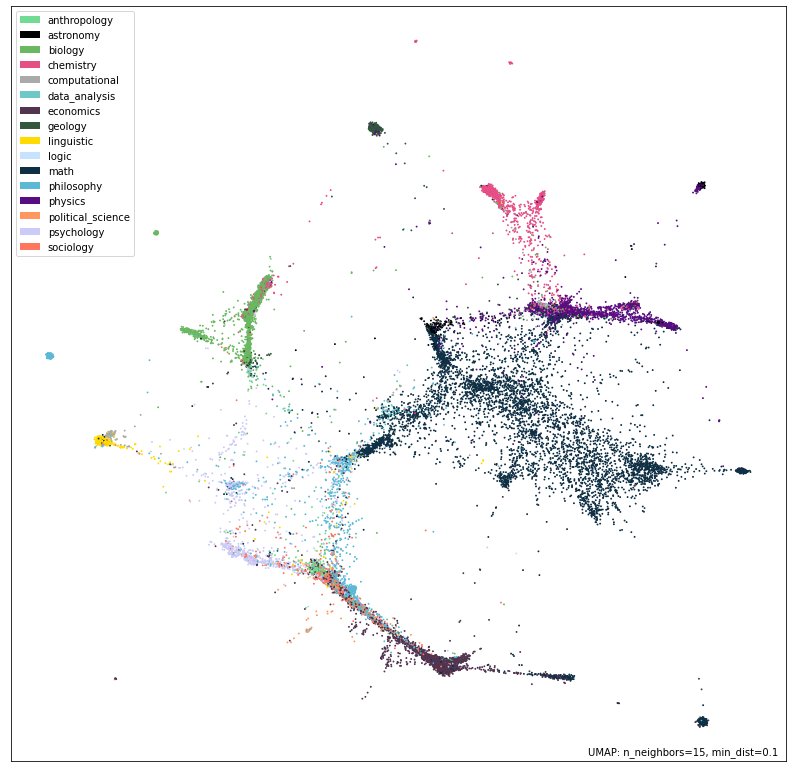

In [177]:
umap.plot.points(
    _mpr,
    labels=np.array(g.vs["field"]),
    color_key=field_color_df.set_index("field").to_dict()["color"],
    width=1000,
    height=1000
)

### category network visualization

In [235]:
c_g = ig.Graph()

In [236]:
c_g.add_vertices(cat_df["category"].values)

In [237]:
c_g.add_edges(cat_edges[["edge_1", "edge_2"]].values)

In [234]:
cat_df["size"] = cat_df["degree"].apply(lambda d: d / 2)

In [238]:
for attr in ["size", "color", "field"]:

    c_g.vs[attr] = cat_df[attr].values

In [248]:
c_g.es["color"] = cat_edges["color"].values

In [268]:
cat_edges

,edge_1,edge_2,weight,color
0,17th-century_mathematicians,18th-century_mathematicians,19,#0E2F44
1,17th-century_mathematicians,19th-century_mathematicians,1,#0E2F44
2,17th-century_mathematicians,20th-century_mathematicians,1,#0E2F44
3,17th-century_mathematicians,21st-century_mathematicians,1,#0E2F44
4,17th-century_mathematicians,American_mathematicians,1,#0E2F44
...,...,...,...,...
1091,Socioeconomics,Sociology_books,1,#523450
1092,Sociolinguistics,Sociology,3,#ffdb00
1093,Soviet_mathematicians,Theoretical_physics,1,#0E2F44
1094,Soviet_mathematicians,Women_mathematicians,6,#0E2F44


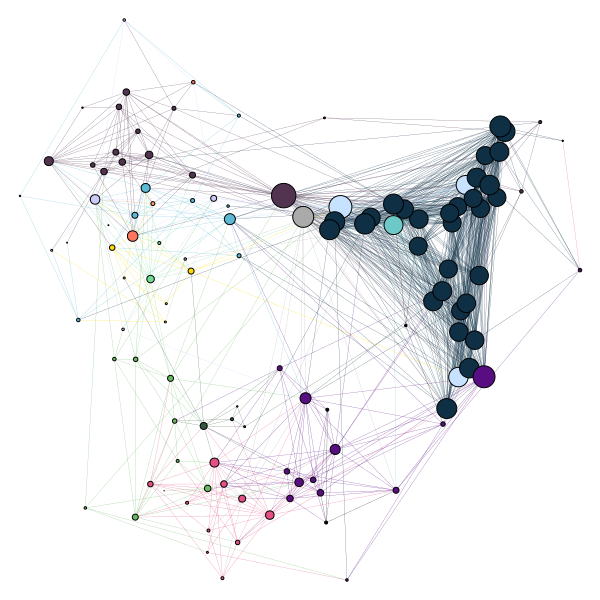

In [255]:
ig.plot(c_g, layout=c_layout, edge_width=0.2)

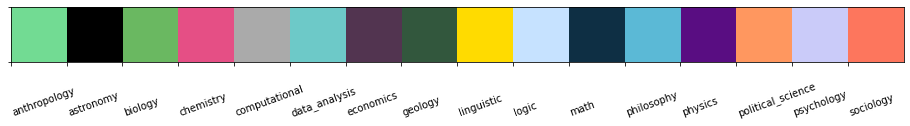

In [262]:
sns.palplot(field_color_df["color"])
for idx, f in enumerate(field_color_df["field"]):
    plt.text(idx - 0.5, 1.5, f, rotation=20)